In [1]:
# cd drive

In [2]:
# %cd My\ Drive

In [3]:
# cd ITSP/handwritten

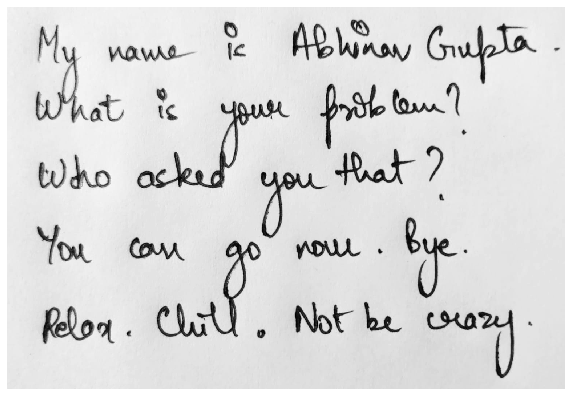

In [69]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

img = rgb2gray(imread("handwritten5.jpg"))
# img = img[:img.shape[0]-20]
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

In [70]:
img[100]

array([0.91481176, 0.9108902 , 0.9108902 , ..., 0.89353725, 0.89353725,
       0.89353725])

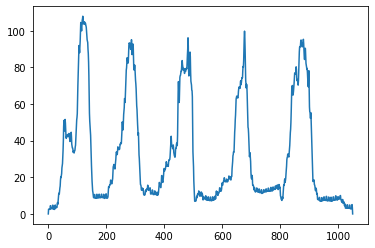

In [71]:
from skimage.filters import sobel
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

sobel_image = sobel(img)
hpp = horizontal_projections(sobel_image)
plt.plot(hpp)
plt.show()

In [72]:
print(hpp.shape)
print(np.max(hpp))
print(np.min(hpp))

(1051,)
107.87559884839597
0.0


threshold  43.15023953935839
757


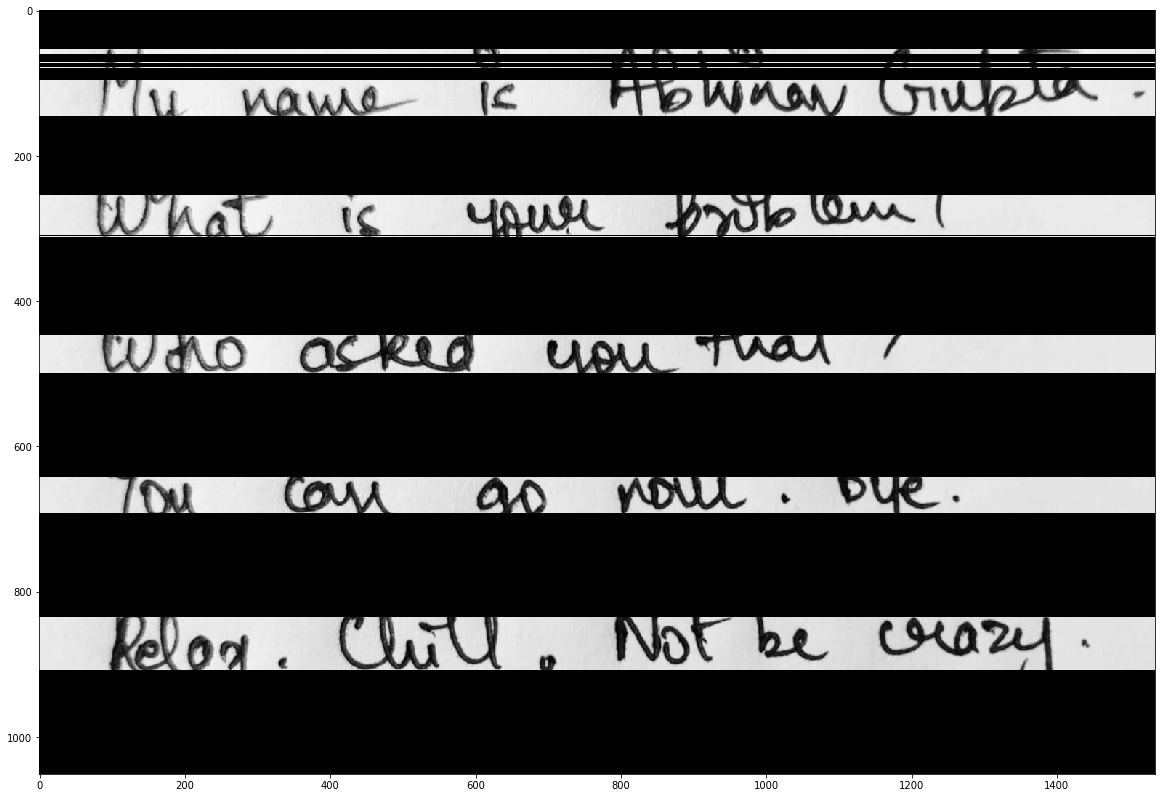

In [74]:
### Scope: Localized peaks ###

#find the midway where we can make a threshold and extract the peaks regions
#divider parameter value is used to threshold the peak values from non peak values.
def find_peak_regions(hpp, divider=2):
    #as threshold increases black region increases
    threshold = (np.max(hpp)-np.min(hpp))/divider
    print("threshold ", threshold)
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            # print(hppv)
            peaks.append([i, hppv])
    return peaks

# Basically peaks gives us a list of lists, where the sum is less than threshold. 
# This indicates that these indexed rows contain whitespace and not text (seems counterintuitive)
peaks = find_peak_regions(hpp)
#748 in case of handwritten3.jpg
print(len(peaks))

peaks_index = np.array(peaks)[:,0].astype(int)

segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(20,20))
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [75]:
###########Scope in ...value > ?1? ############

#group the peaks into walking windows
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(peaks_index)


In [76]:
min_cluster_size = img.shape[0]/20
hpp_clusters = [cluster for cluster in hpp_clusters if len(cluster)>=min_cluster_size]
print(len(hpp_clusters))

6


In [77]:
#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

In [78]:
#Scan the paths to see if there are any blockers.
from skimage.filters import threshold_otsu
from skimage.util import invert

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary


def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    return road_blocks


def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

binary_image = get_binary(img)
# print(binary_image[100])

for cluster_of_interest in hpp_clusters:
    print(cluster_of_interest)
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    road_blocks = get_road_block_regions(nmap)
    road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
    #create the doorways
    for index, road_blocks in enumerate(road_blocks_cluster_groups):
        window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
        # print("window image= ",window_image)
        # print(window_image.shape)
        xx = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10]
        # print("here ",xx)
        # print(xx.shape)
        # print(int(window_image.shape[0]/2))
        if xx.shape[0]!=0:
          # print("yoooo",xx.shape)
          binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2)] *= 0

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
[146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253]
[312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 

In [79]:
#now that everything is cleaner, its time to segment all the lines using the A* algorithm
line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    print(path.shape)
    offset_from_top = cluster_of_interest[0]
    try:
      path[:,0] += offset_from_top
    except:
      pass
    line_segments.append(path)

(1535, 2)
(0,)
(0,)
(1587, 2)
(0,)
(1563, 2)


In [80]:
line_segments = [line for line in line_segments if line.shape != (0,)]

In [81]:
cluster_of_interest = hpp_clusters[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
# plt.figure(figsize=(20,20))
# plt.imshow(invert(nmap), cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
try:
  plt.plot(path[:,1], path[:,0])
except:
  pass

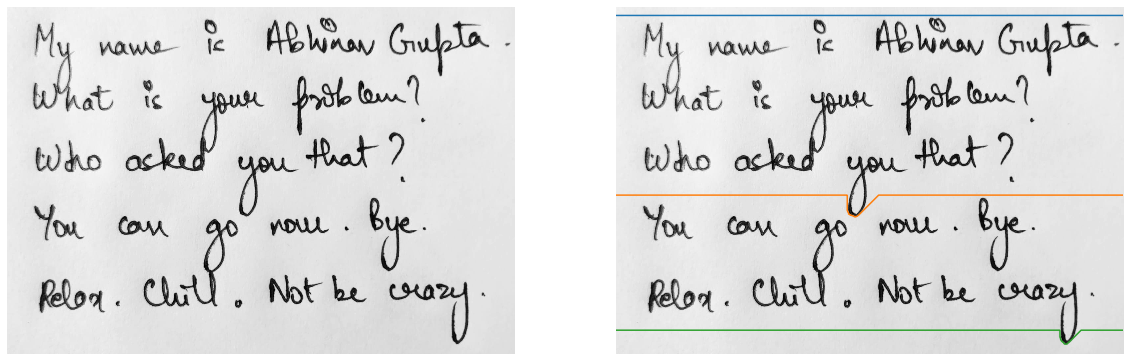

In [82]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in line_segments:
    try:
      ax[1].plot((path[:,1]), path[:,0])
    except:
      pass
ax[1].axis("off")
ax[0].axis("off")
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

In [62]:
## add an extra line to the line segments array which represents the last bottom row on the image
# last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), np.arange(img.shape[1]))).astype(int), axis=0)
# line_segments.append(last_bottom_row)

lower_line  [[  74 1503]
 [  74 1502]
 [  74 1501]
 ...
 [  74    3]
 [  74    2]
 [  74    1]]
upper line  [[ 243 1503]
 [ 243 1502]
 [ 243 1501]
 ...
 [ 243    3]
 [ 243    2]
 [ 243    1]]
lower_line  [[ 243 1503]
 [ 243 1502]
 [ 243 1501]
 ...
 [ 243    3]
 [ 243    2]
 [ 243    1]]
upper line  [[ 398 1503]
 [ 398 1502]
 [ 398 1501]
 ...
 [ 398    3]
 [ 398    2]
 [ 398    1]]
lower_line  [[ 398 1503]
 [ 398 1502]
 [ 398 1501]
 ...
 [ 398    3]
 [ 398    2]
 [ 398    1]]
upper line  [[ 556 1503]
 [ 556 1502]
 [ 556 1501]
 ...
 [ 556    3]
 [ 556    2]
 [ 556    1]]
lower_line  [[ 556 1503]
 [ 556 1502]
 [ 556 1501]
 ...
 [ 556    3]
 [ 556    2]
 [ 556    1]]
upper line  [[ 704 1503]
 [ 704 1502]
 [ 704 1501]
 ...
 [ 704    3]
 [ 704    2]
 [ 704    1]]
lower_line  [[ 704 1503]
 [ 704 1502]
 [ 704 1501]
 ...
 [ 704    3]
 [ 704    2]
 [ 704    1]]
upper line  [[ 846 1503]
 [ 846 1502]
 [ 846 1501]
 ...
 [ 846    3]
 [ 846    2]
 [ 846    1]]


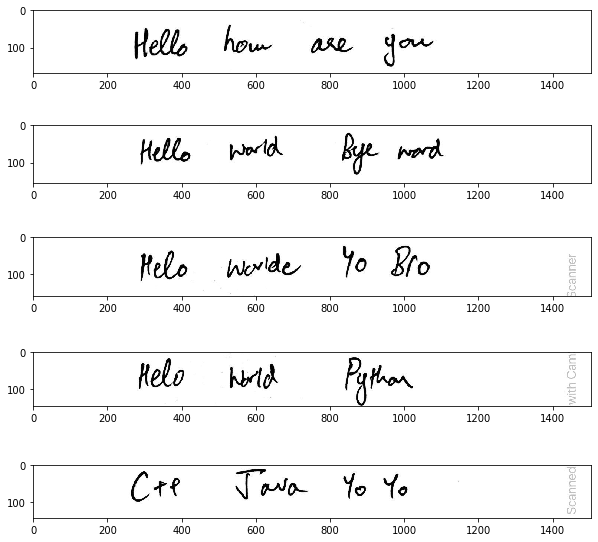

In [63]:
line_images = []
def extract_line_from_image(image, lower_line, upper_line):
#     print("lower_line ",lower_line)
#     print("upper line ",upper_line)
    img_copy = np.copy(image)
    try:
      lower_boundary = np.min(lower_line[:, 0])
      upper_boundary = np.min(upper_line[:, 0])
      r, c = img_copy.shape
      for index in range(c-1):
          img_copy[0:lower_line[index, 0], index] = 255
          img_copy[upper_line[index, 0]:r, index] = 255
          return img_copy[lower_boundary:upper_boundary, :]
    except:
      pass
    return img_copy
    

line_count = len(line_segments)
fig, ax = plt.subplots(figsize=(10,10), nrows=line_count-1)
for line_index in range(line_count-1):
    line_image = extract_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
    line_images.append(line_image)
    ax[line_index].imshow(line_image, cmap="gray")

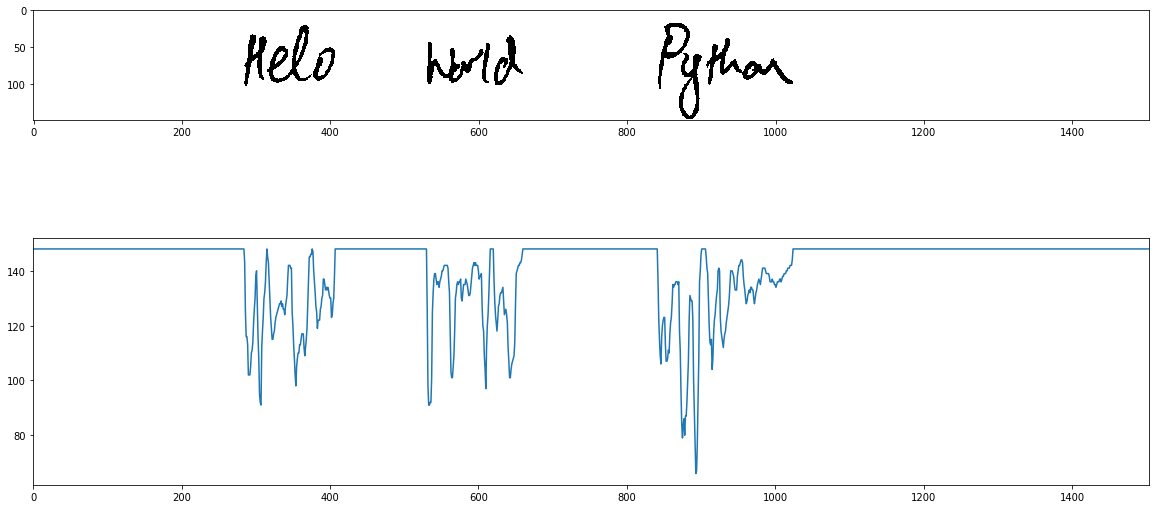

In [64]:
from skimage.filters import threshold_otsu

#binarize the image, guassian blur will remove any noise in the image
first_line = line_images[3]
thresh = threshold_otsu(first_line)
binary = first_line > thresh

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, first_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [65]:
height = first_line.shape[0]

## we will go through the vertical projections and 
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter. 

print("whitespaces:", whitespace_lengths)
avg_white_space_length = np.mean(whitespace_lengths)
print("average whitespace lenght:", avg_white_space_length)

whitespaces: [285, 1, 1, 124, 5, 182, 6]
average whitespace lenght: 86.28571428571429


In [66]:
## find index of whitespaces which are actually long spaces using the avg_white_space_length
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > avg_white_space_length:
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it
            
print(divider_indexes)

[143, 468, 749]


In [67]:
# lets create the block of words from divider_indexes
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))

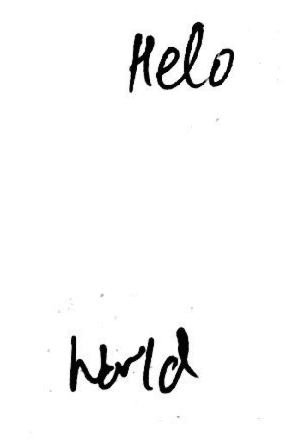

In [68]:
# now plot the findings
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
for index, window in enumerate(dividers):
    ax[index].axis("off")
    ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")